In [563]:
import pandas as pd
import numpy as np
import os
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [564]:
#read NFL data from the last step
final_data =pd.read_csv("preprocessed_nfl_data.csv")
pd.set_option("max_rows", None)

final_data.isna().sum()

Unnamed: 0                         0
index                              0
GameId                             0
GameDate                           0
Quarter                            0
Minute                             0
Second                             0
OffenseTeam                        0
DefenseTeam                        0
Down                               0
ToGo                               0
YardLine                           0
SeriesFirstDown                    0
Description                        0
SeasonYear                         0
Yards                              0
Formation                          0
PlayType                           0
IsRush                             0
IsPass                             0
IsIncomplete                       0
IsTouchdown                        0
PassType                       34649
IsChallenge                        0
IsChallengeReversed                0
IsInterception                     0
IsFumble                           0
I

In [565]:
trimmed_final_data=final_data[~final_data['success'].isna()]

print(trimmed_final_data.shape)

(92000, 107)


In [566]:
rush_col = pd.get_dummies(trimmed_final_data.RushDirection, prefix='Rush_')

pass_col = pd.get_dummies(trimmed_final_data.PassType, prefix='Pass_')

Formation_col = pd.get_dummies(trimmed_final_data.Formation, prefix='Formation')

Down_col = pd.get_dummies(trimmed_final_data.Down, prefix='Down_')

trimmed_final_data = pd.concat([trimmed_final_data, rush_col, pass_col, Down_col], axis=1)

pd.set_option("max_rows", None)


final_data = trimmed_final_data[pass_col.columns.append(rush_col.columns).append(Formation_col.columns).\
                                append(Down_col.columns).append(trimmed_final_data[['OffenseTeam', 'DefenseTeam', 'success']].columns)]

final_data.shape

(92000, 35)

In [766]:
#Select all the entries with OffenseTeam as MIA / and DefenseTeam as MIA

MIA_offense = final_data.loc[final_data.OffenseTeam == 'MIA']
BAL_offense = final_data.loc[final_data.OffenseTeam == 'BAL']

CAR_defense = final_data.loc[final_data.DefenseTeam == 'CAR']
ARI_defense = final_data.loc[final_data.DefenseTeam == 'ARI']


print(f"Shape of offense feature is {MIA_offense.shape}")






Shape of offense feature is (2718, 35)


### Get all numeric features of each of 32 teams, flattern the matrix,  and create a PCA plot to see if teams can be separated by offense or defense

In [568]:
all_NFL_teams = list(set(final_data.OffenseTeam))

print(f"There are in total {len(all_NFL_teams)} NFL Teams")
print(f"Here are the list of all NFL teams:\n{all_NFL_teams}")

There are in total 32 NFL Teams
Here are the list of all NFL teams:
['PIT', 'SF', 'SEA', 'NO', 'DET', 'DEN', 'WAS', 'CIN', 'GB', 'TEN', 'IND', 'LAC', 'LA', 'MIA', 'CLE', 'DAL', 'MIN', 'NYJ', 'BUF', 'KC', 'ARI', 'CAR', 'ATL', 'CHI', 'HOU', 'LV', 'NE', 'TB', 'BAL', 'NYG', 'JAX', 'PHI']


In [569]:
Offense_flatten_df = pd.DataFrame([np.array(final_data.loc[final_data.OffenseTeam == TeamX].\
                                     select_dtypes(exclude='object')).flatten() for TeamX in all_NFL_teams])


Defense_flatten_df = pd.DataFrame([np.array(final_data.loc[final_data.DefenseTeam == TeamX].\
                                     select_dtypes(exclude='object')).flatten() for TeamX in all_NFL_teams])

print(f"Combined Offense data shape is {Offense_flatten_df.shape}")
print(f"Combined Defense data shape is {Defense_flatten_df.shape}")




Combined Offense data shape is (32, 101640)
Combined Defense data shape is (32, 101574)


### PCA visualization of Offense and Defense combined dataframe

In [722]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

offense_scale = pd.DataFrame(scale(Offense_flatten_df), index=all_NFL_teams)

offense_scale.fillna(method = 'pad', axis=1, inplace=True)

offense_pca = PCA().fit(offense_scale)

offense_pca_x = offense_pca.transform(offense_scale)

print(offense_pca_x.shape)

(32, 32)


In [723]:
pca_df = pd.DataFrame({'PC1': offense_pca_x[:, 0], 'PC2': offense_pca_x[:, 1]}, index=all_NFL_teams)
pca_df.head()


#get the overall rank of offense for the season of 2020

Top5= ['KC', 'BUF', 'TEN', 'MIN', 'GB']
Top10= ['ARI', 'TB', 'LV', 'LAC', 'IND']
Top15= ['LA', 'NO', 'HOU', 'DAL', 'SF']
Top20= ['CLE', 'SEA', 'ATL', 'BAL', 'DET']
Top25 = ['CAR', 'MIA', 'DEN', 'PHI', 'PIT']
Last = ['CHI', 'NE', 'JAX', 'CIN', 'WAS', 'NYG', 'NYJ']


pca_df['Rank'] = None

pca_df.loc[Top5, 'Rank'] = 'Top5'

pca_df.loc[Top10, 'Rank'] = '6-10'

pca_df.loc[Top15, 'Rank'] = '11-15'

pca_df.loc[Top20, 'Rank'] = '16-20'

pca_df.loc[Top25, 'Rank'] = '21-25'

pca_df.loc[Last, 'Rank'] = '26-32'


print(pca_df);

            PC1         PC2   Rank
PIT  -70.602755   43.999333  21-25
SF   -15.815259   -2.050822  11-15
SEA   79.081156   -4.287451  16-20
NO    -2.478395   -9.270273  11-15
DET  -48.232378   29.371550  16-20
DEN  -84.586120   38.481837  21-25
WAS    2.219720   -4.559631  26-32
CIN  -70.181834   12.287285  26-32
GB   -80.218380   25.272250   Top5
TEN -102.273386  -69.466120   Top5
IND  -18.910822   10.996609   6-10
LAC  -37.334038   12.785711   6-10
LA    93.784305 -116.573339  11-15
MIA  359.359468  175.070551  21-25
CLE  -76.101930   35.381628  16-20
DAL   -3.914016   -1.147587  11-15
MIN  -28.666387    8.876590   Top5
NYJ  -42.605387  -23.677951  26-32
BUF  -32.576254   -0.195178   Top5
KC   -11.506713   -1.908197   Top5
ARI  -63.305196  -22.064690   6-10
CAR    9.226810  -10.464199  21-25
ATL  -40.745551   32.364863  16-20
CHI  -41.107861   12.354415  26-32
HOU  -69.170124  -43.993219  11-15
LV   -18.221801    8.403098   6-10
NE    12.436905  -27.534832  26-32
TB   -31.265879   20

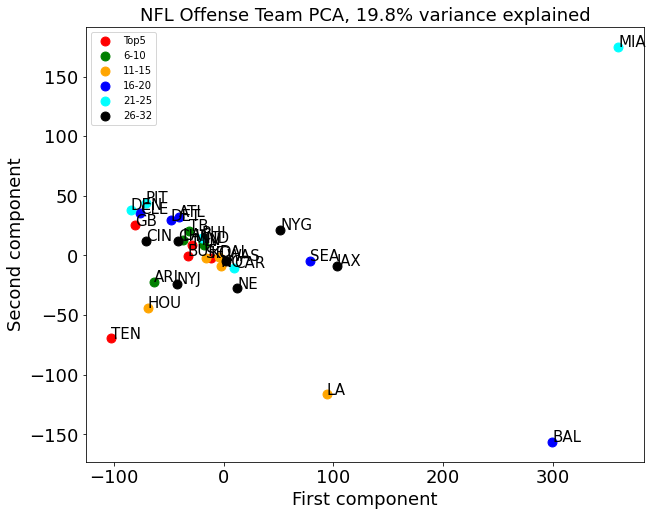

In [724]:
x = pca_df.PC1
y = pca_df.PC2

#quartiles = pca_df.Quartile
Teams = pca_df.index
pc_var = 100 * offense_pca.explained_variance_ratio_.cumsum()[1]
fig, ax = plt.subplots(figsize=(10,8))
color_vec = ['red', 'green', 'orange', 'blue', 'cyan', 'black']
rank_vec = ['Top5', '6-10', '11-15', '16-20', '21-25', '26-32']
for q in rank_vec:
    im = pca_df.Rank == q
    ax.scatter(x=x[im], y=y[im], label=q, color=color_vec[rank_vec.index(q)], s=80)
ax.set_xlabel('First component', size=18)
ax.set_ylabel('Second component', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend()

ax.set_title(f'NFL Offense Team PCA, {pc_var:.1f}% variance explained', size=18)
for s, x, y in zip(pca_df.index, x, y):
    plt.annotate(s, (x, y), size=15)

    
plt.savefig('NFL_offense.png', dpi=500)   

In [573]:
defense_scale = pd.DataFrame(scale(Defense_flatten_df), index=all_NFL_teams)

defense_scale.fillna(method = 'pad', axis=1, inplace=True)

defense_pca = PCA().fit(defense_scale)

defense_pca_x = defense_pca.transform(defense_scale)

print(defense_pca_x.shape)

(32, 32)


In [574]:
pca_df = pd.DataFrame({'PC1': defense_pca_x[:, 0], 'PC2': defense_pca_x[:, 1]}, index=all_NFL_teams)
pca_df.head()


#get the overall rank of defense for the season of 2020

Top5= ['LA', 'WAS', 'PIT', 'NO', 'SF']
Top10= ['TB', 'BAL', 'IND', 'GB', 'LAC']
Top15= ['CHI', 'NYG', 'ARI', 'BUF', 'NE']
Top20= ['KC', 'CLE', 'CAR', 'PHI', 'MIA']
Top25 = ['DEN', 'SEA', 'DAL', 'NYJ', 'LV']
Last = ['CIN', 'MIN', 'TEN', 'ATL', 'HOU', 'JAX', 'DET']


pca_df['Rank'] = None

pca_df.loc[Top5, 'Rank'] = 'Top5'

pca_df.loc[Top10, 'Rank'] = '6-10'

pca_df.loc[Top15, 'Rank'] = '11-15'

pca_df.loc[Top20, 'Rank'] = '16-20'

pca_df.loc[Top25, 'Rank'] = '21-25'

pca_df.loc[Last, 'Rank'] = '26-32'


print(pca_df);

            PC1         PC2   Rank
PIT  -52.279024    6.593165   Top5
SF   -97.296903   24.723373   Top5
SEA  -51.482035  -26.964757  21-25
NO   -64.414797    3.572364   Top5
DET  -59.456824  -64.273986  26-32
DEN  -39.048309   -7.907827  21-25
WAS  -81.769201  -10.147882   Top5
CIN   36.829783  100.490139  26-32
GB     0.424831   14.806481   6-10
TEN   -9.374387   24.517590  26-32
IND  -15.534650    1.776836   6-10
LAC   57.462915  -12.311223   6-10
LA   -82.537209   15.248303   Top5
MIA    4.678050   52.028024  16-20
CLE  -31.540514  -15.469511  16-20
DAL  -14.746098    7.328342  21-25
MIN  -44.807136   -8.276461  26-32
NYJ  -61.562245  -59.742798  21-25
BUF -103.644426   26.417774  11-15
KC   -18.887586    3.537149  16-20
ARI  115.682728  188.601343  11-15
CAR  391.989389  -67.837212  16-20
ATL  -47.872353  -27.420556  26-32
CHI  -69.817121  -64.481639  11-15
HOU  -46.564316   -8.800617  26-32
LV    26.369012   37.562662  21-25
NE   189.318794  -37.728400  11-15
TB   -21.807299    2

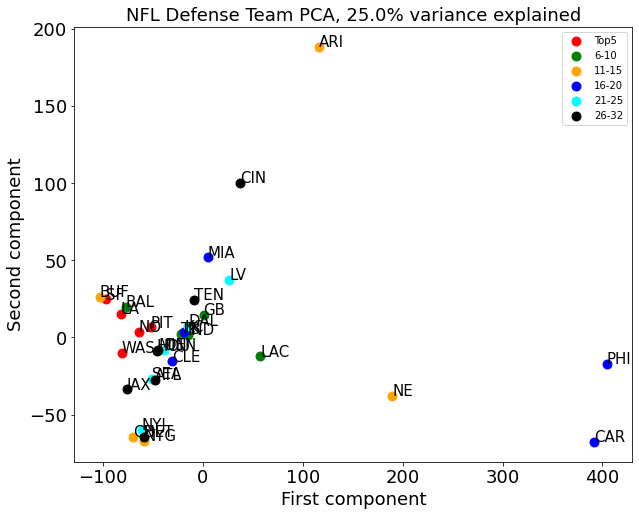

In [720]:
x = pca_df.PC1
y = pca_df.PC2

#quartiles = pca_df.Quartile
Teams = pca_df.index
pc_var = 100 * defense_pca.explained_variance_ratio_.cumsum()[1]
fig, ax = plt.subplots(figsize=(10,8))
color_vec = ['red', 'green', 'orange', 'blue', 'cyan', 'black']
rank_vec = ['Top5', '6-10', '11-15', '16-20', '21-25', '26-32']
for q in rank_vec:
    im = pca_df.Rank == q
    ax.scatter(x=x[im], y=y[im], label=q, color=color_vec[rank_vec.index(q)], s=80)
ax.set_xlabel('First component', size=18)
ax.set_ylabel('Second component', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend()

ax.set_title(f'NFL Defense Team PCA, {pc_var:.1f}% variance explained', size=18)
for s, x, y in zip(pca_df.index, x, y):
    plt.annotate(s, (x, y), size=15)

    
plt.savefig('NFL_defense.png', dpi=500)   

## Obtaining all numeric features from the final data and training against Yards


In [781]:
full_features = ARI_defense.select_dtypes(exclude='object')

print(full_features.head())

final_labels = ARI_defense.success

final_features = full_features.drop(columns=['success'])

final_features = final_features.reset_index()

print(final_features.shape)

     Pass__(SHOTGUN) 10-THILL  Pass__DEEP LEFT  Pass__DEEP MIDDLE  \
379                         0                0                  0   
380                         0                0                  0   
381                         0                0                  0   
382                         0                0                  0   
383                         0                0                  0   

     Pass__DEEP RIGHT  Pass__INTENDED FOR  Pass__INTERCEPTED BY  \
379                 0                   0                     0   
380                 0                   0                     0   
381                 0                   0                     0   
382                 0                   0                     0   
383                 0                   0                     0   

     Pass__LEFT TO  Pass__MIDDLE TO  Pass__MIDDLE [55-FCLARK]  \
379              0                0                         0   
380              0                0                 

In [782]:
#randomly selected 10000 features

#subsample_size = 10000

#selected_indice = np.random.choice(range(len(final_labels)), subsample_size, replace=False)

selected_features = final_features.drop(columns=['index'])



#selected_features = selected_features.drop(columns='index')

selected_labels = final_labels

## Split the data into train and test sets

In [783]:
X_train, X_test, y_train, y_test = train_test_split(selected_features, 
                                                    selected_labels, test_size=0.3, 
                                                    random_state=47)

In [784]:
print(f"training data size is {X_train.shape}")
print(f"training label size is {y_train.shape}")

print(f"test data size is {X_test.shape}")
print(f"test label size is {y_test.shape}")

print(X_train.head())

training data size is (2062, 32)
training label size is (2062,)
test data size is (885, 32)
test label size is (885,)
      Pass__(SHOTGUN) 10-THILL  Pass__DEEP LEFT  Pass__DEEP MIDDLE  \
2435                         0                0                  0   
1662                         0                0                  0   
917                          0                0                  0   
1976                         0                0                  0   
1456                         0                0                  0   

      Pass__DEEP RIGHT  Pass__INTENDED FOR  Pass__INTERCEPTED BY  \
2435                 0                   0                     0   
1662                 0                   0                     0   
917                  0                   0                     0   
1976                 0                   0                     0   
1456                 0                   0                     0   

      Pass__LEFT TO  Pass__MIDDLE TO  Pass__MIDDLE [

## Train the data with Random Forest model, grid search to identify the best setting

In [785]:
#Define the RF pipeline
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [786]:
#Check the model prediction result on default values
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [787]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.03291437, -0.07622838, -0.04866642, -0.0299874 ,  0.0470546 ])

In [788]:
print(f"For base model, the cv score mean  = {np.mean(rf_cv_scores)}, std = {np.std(rf_cv_scores)}")


For base model, the cv score mean  = -0.02814839351482885, std = 0.041022581966902505


## Hyperparameters tuning

In [789]:
#build a search grid
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [790]:
#grid search on the training dataset
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [791]:
#Print the best params (`best_params_` attribute) from the grid search
print("best model settings:\n")
rf_grid_cv.best_params_

best model settings:



{'randomforestregressor__n_estimators': 10,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [792]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.03590388, -0.08390888, -0.03443792, -0.02259563,  0.04229802])

In [895]:
regr = rf_grid_cv.best_estimator_

regr.fit(X_train, y_train)

predict_results  = regr.predict(X_test)

print(X_test.iloc[np.argmax(predict_results), :])

print(y_test.iloc[np.argmax(predict_results)])

print(np.max(predict_results))

Pass__(SHOTGUN) 10-THILL       0
Pass__DEEP LEFT                0
Pass__DEEP MIDDLE              0
Pass__DEEP RIGHT               0
Pass__INTENDED FOR             0
Pass__INTERCEPTED BY           0
Pass__LEFT TO                  0
Pass__MIDDLE TO                0
Pass__MIDDLE [55-FCLARK]       0
Pass__MIDDLE. PENALTY          0
Pass__NOT LISTED               0
Pass__RIGHT TO                 0
Pass__SHORT LEFT               0
Pass__SHORT MIDDLE             1
Pass__SHORT RIGHT              0
Pass__[58-H.LANDRY III]        0
Rush__CENTER                   0
Rush__LEFT END                 0
Rush__LEFT GUARD               0
Rush__LEFT TACKLE              0
Rush__RIGHT END                0
Rush__RIGHT GUARD              0
Rush__RIGHT TACKLE             0
Formation_NO HUDDLE            0
Formation_NO HUDDLE SHOTGUN    0
Formation_SHOTGUN              0
Formation_UNDER CENTER         1
Formation_WILDCAT              0
Down__1                        0
Down__2                        0
Down__3   

In [793]:
print(f"For Selected Best model, the cv score mean  = {np.mean(rf_best_scores)}, std = {np.std(rf_best_scores)}")

For Selected Best model, the cv score mean  = -0.026909659611390403, std = 0.04048406166196725


## Check on the importance of each feature based on the best random forest model

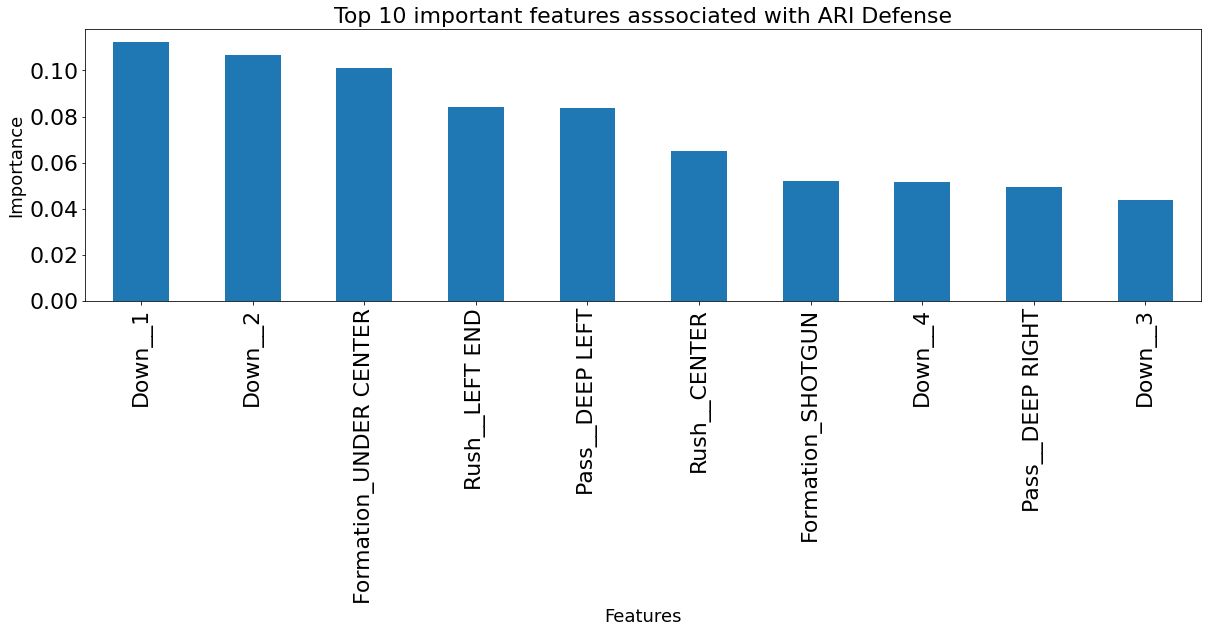

In [794]:
#Check the importance of each feature based on best random forest regressor obtained from grid search
plt.subplots(figsize=(20, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:10]
rf_feat_imps.plot(kind='bar')

#print(rf_feat_imps.index.tolist()[:10])

plt.xlabel('Features', size=18)
plt.ylabel('Importance', size=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('Top 10 important features asssociated with ARI Defense', size=22);

plt.savefig('ARI_defense_key_features.png', dpi=500, bbox_inches="tight") 

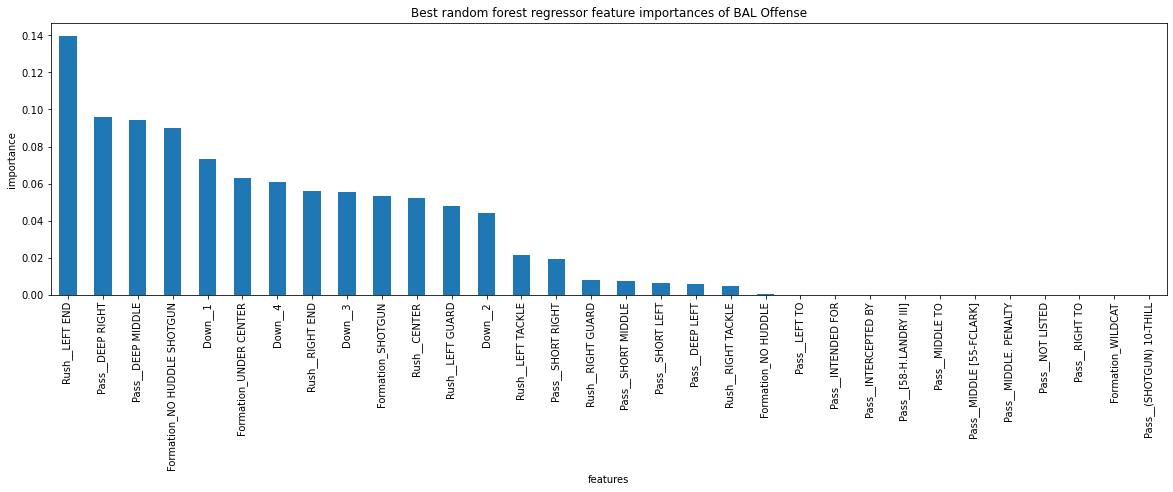

In [645]:
#Check the importance of each feature based on best random forest regressor obtained from grid search
plt.subplots(figsize=(20, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances of BAL Offense');

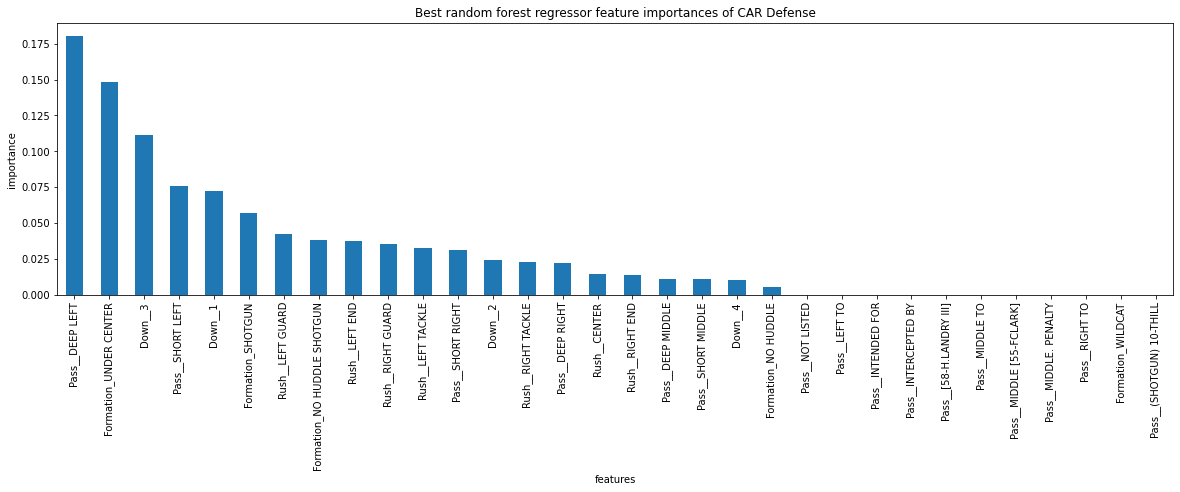

In [618]:
#Check the importance of each feature based on best random forest regressor obtained from grid search
plt.subplots(figsize=(20, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances of CAR Defense');

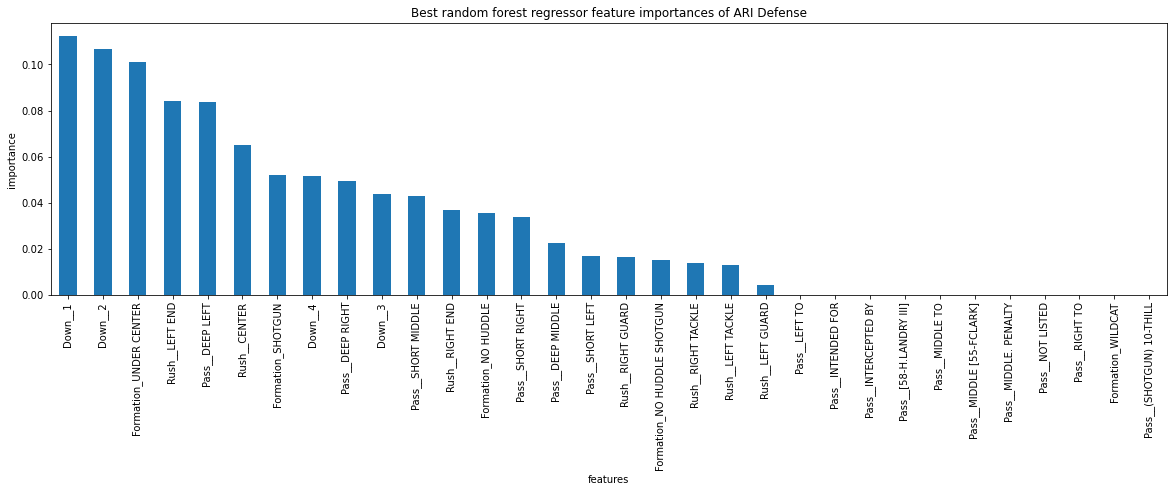

In [589]:
#Check the importance of each feature based on best random forest regressor obtained from grid search
plt.subplots(figsize=(20, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances of ARI Defense');

In [824]:
#Check which numeric variables are correlated with Yards in the dataset

#get all numeric variables from filtered_data_v3
success_cat = []

for ratio in trimmed_final_data.success:
    if ratio == 0:
        success_cat.append('No Gain or Lost Yards')
    elif ratio<1:
        success_cat.append('')
    else:
        success_cat.append('Success')
        
        
trimmed_final_data['success_cat'] = success_cat


MIA_Offense_final_data = trimmed_final_data.loc[trimmed_final_data.OffenseTeam == 'MIA', :]
KC_Offense_final_data = trimmed_final_data.loc[trimmed_final_data.OffenseTeam == 'KC', :]
MIA_Defense_final_data = trimmed_final_data.loc[trimmed_final_data.DefenseTeam == 'BUF', :]
NYJ_Defense_final_data = trimmed_final_data.loc[trimmed_final_data.DefenseTeam == 'CIN', :]

plot_df = MIA_offense_final_data.groupby(['Formation', 'success_cat']).size()

{nan, 'SHORT LEFT', 'DEEP MIDDLE', 'SHORT RIGHT', 'SHORT MIDDLE', 'DEEP RIGHT', 'DEEP LEFT'}


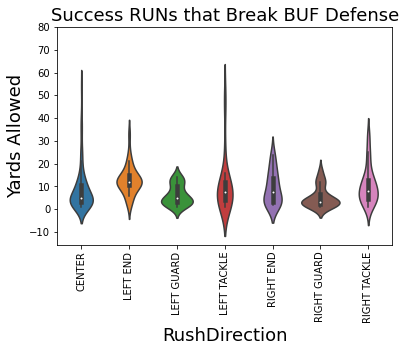

In [886]:
def success_count(df):
    return_df = pd.DataFrame(df.value_counts("success_cat")/df.shape[0]).T
    
    #print(return_df)
    #return_df.index = ['1st Down', '2nd Down', '3rd Down', '4th Down']
    return(return_df)
plot_df = BAL_offense_final_data.groupby('RushDirection').apply(success_count)



sns.violinplot(y="Yards", 
                x="RushDirection", 
                data=MIA_Defense_final_data[MIA_Defense_final_data.success>=1].sort_values('RushDirection'), ylim=(0,10))

#plt.title("LA Defense on Passes", size=20)

print(set(BAL_Defense_final_data.PassType))

plt.xlabel('RushDirection', size=18)
plt.ylabel('Yards Allowed', size=18)
plt.xticks(rotation='vertical')
plt.yticks(np.arange(-10, 90, step=10))



plt.title('Success RUNs that Break BUF Defense', size=18);

plt.savefig('BUF_RUN_defense_breakdown.png', dpi=500, bbox_inches="tight") 

{nan, 'DEEP MIDDLE', 'SHORT RIGHT', 'SHORT MIDDLE', 'DEEP RIGHT', 'SHORT LEFT', 'DEEP LEFT'}


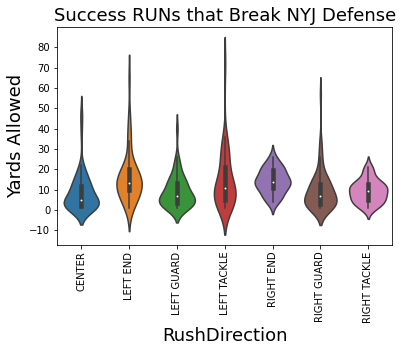

In [885]:
#plot_df = NYJ_offense_final_data.groupby('PassType')#.apply(success_count)


sns.violinplot(y="Yards", 
                x="RushDirection", 
                data=NYJ_Defense_final_data[NYJ_Defense_final_data.success>=1].sort_values('RushDirection'), ylim=(0,10))

#plt.title("NYJ Defense on Passes", size=20)

print(set(NYJ_Defense_final_data.PassType))

plt.xlabel('RushDirection', size=18)
plt.ylabel('Yards Allowed', size=18)
plt.xticks(rotation='vertical')
plt.yticks(np.arange(-10, 90, step=10))

plt.title('Success RUNs that Break NYJ Defense', size=18);

plt.savefig('NYJ_Pass_defense_breakdown.png', dpi=500, bbox_inches="tight") 

<AxesSubplot:xlabel='Down', ylabel='Yards'>

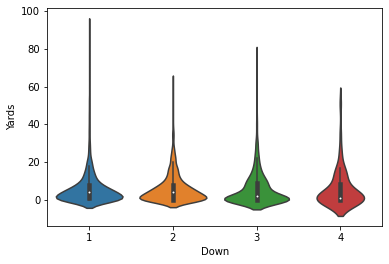

In [667]:
#plot_df = NYJ_offense_final_data.groupby('PassType')#.apply(success_count)


sns.violinplot(y="Yards", 
                x="Down", 
                data=NYJ_Offense_final_data[NYJ_Offense_final_data.success>=0])

<AxesSubplot:xlabel='Down', ylabel='Yards'>

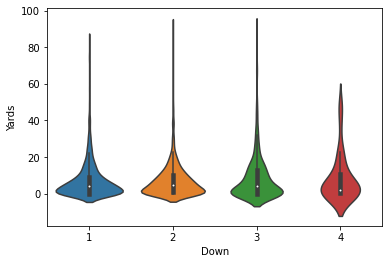

In [664]:
sns.violinplot(y="Yards", 
                x="Down", 
                data=KC_Offense_final_data[KC_Offense_final_data.success>=0])

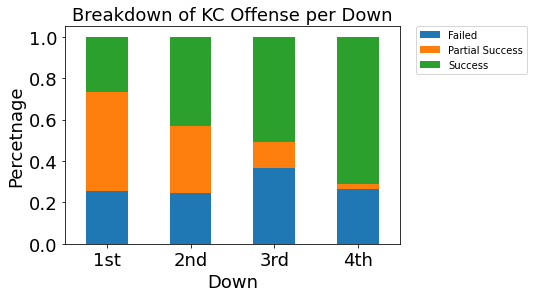

In [875]:

MIA_offense_final_data = trimmed_final_data.loc[trimmed_final_data.OffenseTeam == 'KC', :]


plot_df = MIA_offense_final_data.groupby(['Down', 'success_cat']).size()


plot_df = MIA_offense_final_data.groupby('Down').apply(success_count)
plot_df.fillna(0, inplace=True)

plot_df = plot_df[["Failed", "Partial Success", "Success"]]


plot_df.plot(kind='bar', stacked=True)

#plot_df = plot_df.reset_index()

#plot_df = plot_df.set_index('Down')


#plt.xticks(positions, labels)
plt.xticks(ticks = [0,1,2,3], labels = ['1st', '2nd', '3rd', '4th'], rotation=None)


plt.xlabel('Down', size=18)
plt.ylabel('Percetnage', size=18)
plt.tick_params(axis='both', which='major', labelsize=18)


plt.title('Breakdown of KC Offense per Down', size=18);

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('KC_Offense_Down.png', dpi=500, bbox_inches='tight') 








        Partial Success   Success    Failed
Down                                       
1    0         0.480263  0.266082  0.253655
2    0         0.323800  0.433095  0.243105
3    0         0.124535  0.507435  0.368030
4    0         0.026316  0.710526  0.263158


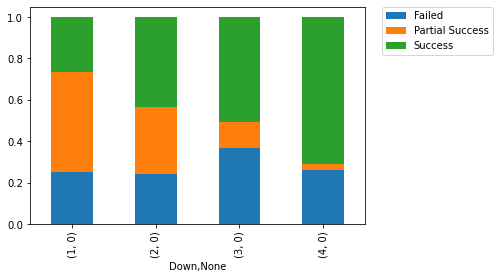

In [829]:
KC_offense_final_data = trimmed_final_data.loc[trimmed_final_data.OffenseTeam == 'KC', :]


plot_df = KC_offense_final_data.groupby(['Down', 'success_cat']).size()


plot_df = KC_offense_final_data.groupby('Down').apply(success_count)
plot_df.fillna(0, inplace=True)

print(plot_df)
plot_df = plot_df[["Failed", "Partial Success", "Success"]]


plot_df.plot(kind='bar', stacked=True)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


success_cat      Partial Success   Success    Failed
RushDirection                                       
CENTER        0         0.600823  0.283951  0.115226
LEFT END      0         0.592857  0.342857  0.064286
LEFT GUARD    0         0.654822  0.258883  0.086294
LEFT TACKLE   0         0.614286  0.285714  0.100000
RIGHT END     0         0.637168  0.274336  0.088496
RIGHT GUARD   0         0.575472  0.311321  0.113208
RIGHT TACKLE  0         0.634615  0.230769  0.134615


<AxesSubplot:xlabel='RushDirection,None'>

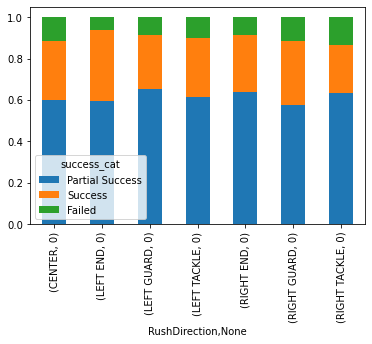

In [706]:
BAL_Defense_final_data = trimmed_final_data.loc[trimmed_final_data.DefenseTeam == 'CIN', :]


plot_df = BAL_Defense_final_data.groupby(['Formation', 'success_cat']).size()


plot_df = BAL_Defense_final_data.groupby('RushDirection').apply(success_count)
plot_df.fillna(0, inplace=True)

print(plot_df)


plot_df.plot(kind='bar', stacked=True)